# Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer, InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
batch_size = 16
image_size = 224

In [3]:
train_path = '/kaggle/input/splitted-and-augmented-ham-15/Splitted_And_Augmented_HAM_15/HAM10K/train_dir'
test_path = '/kaggle/input/splitted-and-augmented-ham-15/Splitted_And_Augmented_HAM_15/HAM10K/test_dir'
val_path = '/kaggle/input/splitted-and-augmented-ham-15/Splitted_And_Augmented_HAM_15/HAM10K/val_dir'

# Dataset generation (Train, Test, Validation)

In [4]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [5]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 54782 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.

Val Batches: 
Found 827 images belonging to 7 classes.


# Main Model Creation

In [6]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [7]:
from tensorflow.keras.applications.resnet import ResNet101

RN101 = ResNet101(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

171446536/171446536 [==============================] - 6s 0us/step


## Fine tuning

In [8]:
MainInput=Input(shape=(image_size, image_size, 3))

In [9]:
resnet = RN101(MainInput)

In [10]:
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((16, 16, 8))(resnet)

In [11]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)

In [12]:
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))

In [13]:
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)

In [14]:
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

In [15]:
num_classes = test_batches.num_classes
print(num_classes)

7


In [16]:
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="softmax")(conv))

model_rn101_ca = Model(inputs=MainInput, outputs=conv)

In [17]:
model_rn101_ca.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 reshape (Reshape)           (None, 16, 16, 8)         0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 128)       50304     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 channel_attention (ChannelA  (None, 16, 16, 128)      2184      
 ttention)                                                   

In [18]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model_rn101_ca.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [19]:
class_weights = {   
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 1.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0  # vasc
                }

In [20]:
checkpoint = ModelCheckpoint(filepath ='RN101_CA.hdf5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
Earlystop = EarlyStopping(monitor='val_accuracy', mode='max', patience=25, min_delta=0.001)

In [21]:
history = model_rn101_ca.fit(train_batches,
                         epochs=50,
                         verbose=2,
                         validation_data=val_batches,
                         callbacks=[checkpoint,Earlystop],
                         class_weight=class_weights)

Epoch 1/50
3424/3424 - 786s - loss: 0.9422 - accuracy: 0.6425 - val_loss: 0.4222 - val_accuracy: 0.8706 - 786s/epoch - 230ms/step
Epoch 2/50
3424/3424 - 676s - loss: 0.3619 - accuracy: 0.8678 - val_loss: 0.3787 - val_accuracy: 0.8936 - 676s/epoch - 198ms/step
Epoch 3/50
3424/3424 - 678s - loss: 0.2028 - accuracy: 0.9261 - val_loss: 0.3757 - val_accuracy: 0.8996 - 678s/epoch - 198ms/step
Epoch 4/50
3424/3424 - 675s - loss: 0.1311 - accuracy: 0.9536 - val_loss: 0.3911 - val_accuracy: 0.8996 - 675s/epoch - 197ms/step
Epoch 5/50
3424/3424 - 679s - loss: 0.0913 - accuracy: 0.9685 - val_loss: 0.3563 - val_accuracy: 0.9105 - 679s/epoch - 198ms/step
Epoch 6/50
3424/3424 - 676s - loss: 0.0681 - accuracy: 0.9758 - val_loss: 0.4020 - val_accuracy: 0.9008 - 676s/epoch - 197ms/step
Epoch 7/50
3424/3424 - 679s - loss: 0.0525 - accuracy: 0.9821 - val_loss: 0.5014 - val_accuracy: 0.8996 - 679s/epoch - 198ms/step
Epoch 8/50
3424/3424 - 680s - loss: 0.0410 - accuracy: 0.9862 - val_loss: 0.4600 - val_acc

### Plotting accuracy and loss

Number of epochs trained: 39


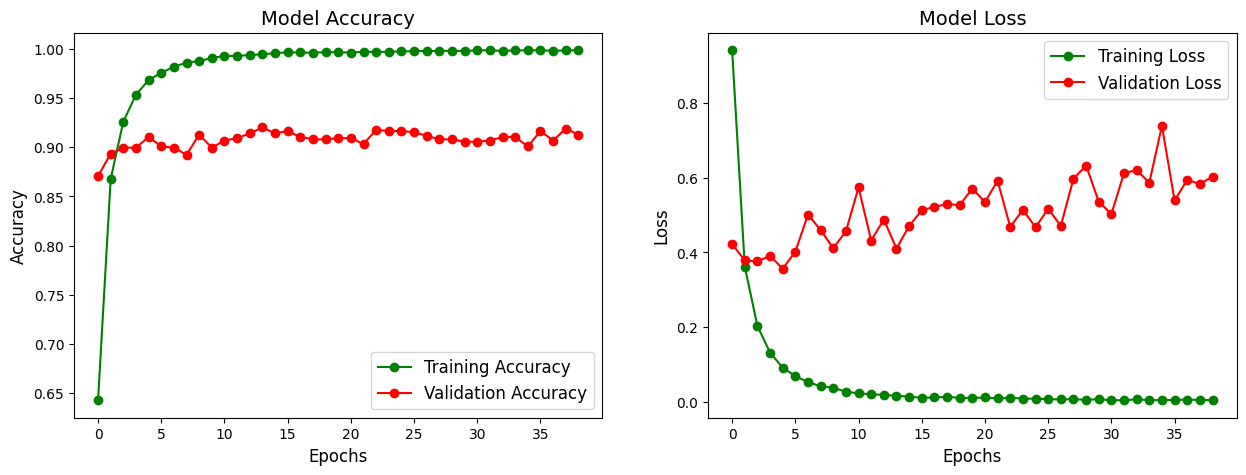

In [22]:
# Determine number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

## History plotting
epochs = [i for i in range(num_epochs_trained)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
ax[0].set_title('Model Accuracy', fontdict=title_font)
legend_font = {'family': 'Times New Roman', 'size': '12', 'weight': 'normal'}
ax[0].legend(prop=legend_font)
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}
ax[0].set_xlabel("Epochs",  fontdict=label_font)
ax[0].set_ylabel("Accuracy",  fontdict=label_font)

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Model Loss', fontdict=title_font)
ax[1].legend(prop=legend_font)
ax[1].set_xlabel("Epochs", fontdict=label_font)
ax[1].set_ylabel("Loss", fontdict=label_font)
plt.show()

In [23]:
from tensorflow.keras import models
model_rn101_ca.load_weights("RN101_CA.hdf5")

In [24]:
predictions = model_rn101_ca.predict(test_batches)

52/52 [==============================] - 17s 268ms/step


In [25]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions

In [26]:
classnames = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

          AK       0.64      0.64      0.64        22
         BCC       0.70      0.70      0.70        27
         BKL       0.70      0.83      0.76        66
          DF       0.83      0.83      0.83         6
         MEL       0.71      0.34      0.46        35
          NV       0.97      0.97      0.97       663
        VASC       0.90      1.00      0.95         9

    accuracy                           0.92       828
   macro avg       0.78      0.76      0.76       828
weighted avg       0.92      0.92      0.91       828



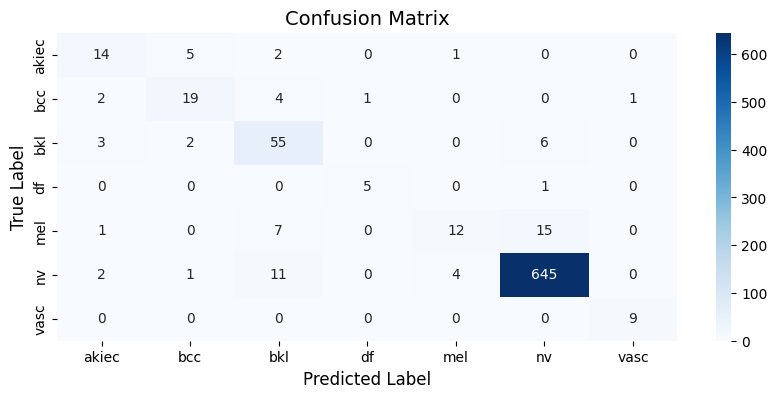

In [27]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

## Results

### Individual Class Accuracy 

In [28]:
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 91.67%
Accuracy for each class:
Class 0: 63.64%
Class 1: 70.37%
Class 2: 83.33%
Class 3: 83.33%
Class 4: 34.29%
Class 5: 97.29%
Class 6: 100.00%


### Individual Class Weighted Precision

In [29]:
report = classification_report(y_true, y_pred, output_dict=True)
# Extract weighted precision for each class
class_precision = {}
for class_label in report.keys():
    if class_label == 'weighted avg':
        class_precision['weighted'] = report[class_label]['precision']
    elif class_label.isdigit():
        class_precision[int(class_label)] = report[class_label]['precision']
print("Weighted precision for each class:")
for i, precision in class_precision.items():
    if i == 'weighted':
        print("Weighted precision: {:.2f}%".format(precision*100))
    else:
        print("Class {}: {:.2f}%".format(i, precision*100))

Weighted precision for each class:
Class 0: 63.64%
Class 1: 70.37%
Class 2: 69.62%
Class 3: 83.33%
Class 4: 70.59%
Class 5: 96.70%
Class 6: 90.00%
Weighted precision: 91.53%


### Individual Class Weighted Recall

In [30]:
report = classification_report(y_true, y_pred, output_dict=True)
# Extract weighted recall for each class
class_recall = {}
for class_label in report.keys():
    if class_label == 'weighted avg':
        class_recall['weighted'] = report[class_label]['recall']
    elif class_label.isdigit():
        class_recall[int(class_label)] = report[class_label]['recall']
print("Weighted recall for each class:")
for i, recall in class_recall.items():
    if i == 'weighted':
        print("Weighted Recall: {:.2f}%".format(recall*100))
    else:
        print("Class {}: {:.2f}%".format(i, recall*100))

Weighted recall for each class:
Class 0: 63.64%
Class 1: 70.37%
Class 2: 83.33%
Class 3: 83.33%
Class 4: 34.29%
Class 5: 97.29%
Class 6: 100.00%
Weighted Recall: 91.67%


### Individual Class Weighted F1-score

In [31]:
report = classification_report(y_true, y_pred, output_dict=True)
# Extract weighted F1-score for each class
class_f1 = {}
for class_label in report.keys():
    if class_label == 'weighted avg':
        class_f1['weighted'] = report[class_label]['f1-score']
    elif class_label.isdigit():
        class_f1[int(class_label)] = report[class_label]['f1-score']
print("Weighted F1-score for each class:")
for i, f1_score in class_f1.items():
    if i == 'weighted':
        print("Weighted F1-score: {:.2f}%".format(f1_score*100))
    else:
        print("Class {}: {:.2f}%".format(i, f1_score*100))

Weighted F1-score for each class:
Class 0: 63.64%
Class 1: 70.37%
Class 2: 75.86%
Class 3: 83.33%
Class 4: 46.15%
Class 5: 96.99%
Class 6: 94.74%
Weighted F1-score: 91.28%


### Individual Class Precision, Recall and F1-score

In [32]:
from sklearn.metrics import precision_recall_fscore_support

precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_true, y_pred, average=None)
print('Class-wise weighted precision, recall, and F1-score:')
for i in range(len(precision_class)):
    print('Class {}: Precision={:.2f}, Recall={:.2f}, F1-score={:.2f}'.format(i, precision_class[i], recall_class[i], f1_class[i]))


Class-wise weighted precision, recall, and F1-score:
Class 0: Precision=0.64, Recall=0.64, F1-score=0.64
Class 1: Precision=0.70, Recall=0.70, F1-score=0.70
Class 2: Precision=0.70, Recall=0.83, F1-score=0.76
Class 3: Precision=0.83, Recall=0.83, F1-score=0.83
Class 4: Precision=0.71, Recall=0.34, F1-score=0.46
Class 5: Precision=0.97, Recall=0.97, F1-score=0.97
Class 6: Precision=0.90, Recall=1.00, F1-score=0.95


### Individual Class Weighted Sensitivity

In [33]:
from imblearn.metrics import sensitivity_score

sensitivity = sensitivity_score(y_true, y_pred, average='weighted')
print("Weighted Sensitivity: ", sensitivity)

# Calculate class-wise sensitivity
sensitivity = sensitivity_score(y_true, y_pred, average=None)

# Print sensitivity score for each class
for i in range(len(sensitivity)):
    print("Class ", i, ":sensitivity =", sensitivity[i])

Weighted Sensitivity:  0.9166666666666666
Class  0 :sensitivity = 0.6363636363636364
Class  1 :sensitivity = 0.7037037037037037
Class  2 :sensitivity = 0.8333333333333334
Class  3 :sensitivity = 0.8333333333333334
Class  4 :sensitivity = 0.34285714285714286
Class  5 :sensitivity = 0.9728506787330317
Class  6 :sensitivity = 1.0


### Individual Class Weighted Specificity

In [34]:
from imblearn.metrics import specificity_score

specificity = specificity_score(y_true, y_pred, average='weighted')
print("Weighted Specificity: ", specificity)

# Calculate class-wise specificity
specificity = specificity_score(y_true, y_pred, average=None)

# Print sensitivity score for each class
for i in range(len(specificity)):
    print("Class ", i, ":specificity=", specificity[i])

Weighted Specificity:  0.8898481466169628
Class  0 :specificity= 0.9900744416873449
Class  1 :specificity= 0.9900124843945068
Class  2 :specificity= 0.968503937007874
Class  3 :specificity= 0.9987834549878345
Class  4 :specificity= 0.9936948297604036
Class  5 :specificity= 0.8666666666666667
Class  6 :specificity= 0.9987789987789988


### Accuracy

In [35]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
import numpy as np
from sklearn.metrics import accuracy_score

Accuracy: 0.9166666666666666


In [36]:
# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9166666666666666
Top-2 Accuracy: 0.9794685990338164
Top-3 Accuracy: 0.9891304347826086


### Weighted Evaluation Measures

In [37]:
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Sensitivity: "+ str(sensitivity_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9153226853557154
Weighted Recall: 0.9166666666666666
Weighted F1-Score: 0.912813137483697
Weighted Sensitivity: 0.9166666666666666
Weighted Specificity: 0.8898481466169628
weighted Roc score: 0.9784443949731012


### Macro Evaluation Measures

In [38]:
print("Macro Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Macro Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Macro F1-Score: "+ str(f1_score(y_true, y_pred, average='macro')))
print("Macro Sensitivity: "+ str(sensitivity_score(y_true, y_pred, average='macro')))
print("Macro Specificity: "+ str(specificity_score(y_true, y_pred, average='macro')))
print("Macro Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='macro')))

Macro Precision: 0.7775002928202205
Macro Recall: 0.7603488326177402
Macro F1-Score: 0.7586932939538593
Macro Sensitivity: 0.7603488326177402
Macro Specificity: 0.9723592590405185
Macro Roc score: 0.9807543533039622


### Micro Evaluation Measures

In [39]:
print("Micro Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Micro Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Micro F1-Score: "+ str(f1_score(y_true, y_pred, average='micro')))
print("Micro Sensitivity: "+ str(sensitivity_score(y_true, y_pred, average='micro')))
print("Micro Specificity: "+ str(specificity_score(y_true, y_pred, average='micro')))

Micro Precision: 0.9166666666666666
Micro Recall: 0.9166666666666666
Micro F1-Score: 0.9166666666666666
Micro Sensitivity: 0.9166666666666666
Micro Specificity: 0.9861111111111112


## ROC

### Compute ROC curve and ROC area for each class

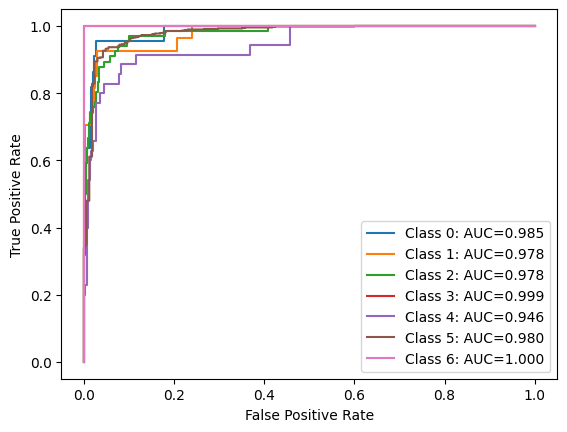

In [40]:
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.3f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## MCC and Kappa Score

In [41]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print("MCC: {:.2f}%".format(mcc*100))
print("Kappa Score: {:.2f}%".format(kappa*100))

MCC: 75.90%
Kappa Score: 75.81%


In [42]:
### Individual Class Wise MCC and Kappa

from sklearn.metrics import confusion_matrix, matthews_corrcoef, cohen_kappa_score
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
conf_mat = confusion_matrix(y_true, y_pred)
mcc_per_class = {}
kappa_per_class = {}

for i in range(len(conf_mat)):
    tp = conf_mat[i][i]
    fp = sum(conf_mat[:, i]) - tp
    fn = sum(conf_mat[i, :]) - tp
    tn = sum(sum(conf_mat)) - tp - fp - fn

    mcc_per_class[i] = matthews_corrcoef([1 if x==i else 0 for x in y_true], [1 if x==i else 0 for x in y_pred])
    kappa_per_class[i] = cohen_kappa_score([1 if x==i else 0 for x in y_true], [1 if x==i else 0 for x in y_pred])

print("MCC per class:")
for i, mcc in mcc_per_class.items():
    print("Class {}: {:.2f}%".format(i, mcc*100))

print("Kappa Score per class:")
for i, kappa in kappa_per_class.items():
    print("Class {}: {:.2f}%".format(i, kappa*100))

MCC per class:
Class 0: 62.64%
Class 1: 69.37%
Class 2: 73.92%
Class 3: 83.21%
Class 4: 47.75%
Class 5: 84.73%
Class 6: 94.81%
Kappa Score per class:
Class 0: 62.64%
Class 1: 69.37%
Class 2: 73.57%
Class 3: 83.21%
Class 4: 44.62%
Class 5: 84.72%
Class 6: 94.68%
